# Click Consensus Distribution

Radio Galaxy Zoo volunteers may disagree on which potential host galaxy is *the* host galaxy for a given radio observation. However, I want to use the volunteers' choices as labels for supervised learning. How do we decide what to use as the "true" label? Can we just take the majority vote?

This notebook will find some distributions of clicks across different objects, with the aim of trying to figure out whether majority vote is a good idea (and how often it is a good idea).

In [1]:
import collections
import pprint
import sys
import timeit
import warnings

import matplotlib.pyplot
import numpy
import scipy.stats
import sklearn.cluster
import sklearn.mixture


sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.show
import crowdastro.rgz_analysis.consensus

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

In [15]:
# PG-means method for finding peaks (from click_consensus).
def make_annotation_signature(annotation):
    """Generates the signature associated with an annotation."""
    if 'radio' not in annotation:
        # Metadata (ignore this).
        return None

    # We want to turn the radio classifications into a unique signature. I can just take all the xmax's and ymax's
    # and put them into some tuples (xmaxs, ymaxs).
    
    # Having no contours is a special case; () to avoid type errors (it's special but it's still valid!)
    if annotation['radio'] == 'No Contours':
        return ()

    xmaxs = tuple(sorted([round(float(r['xmax']), 14) for r in annotation['radio'].values()]))
    ymaxs = tuple(sorted([round(float(r['ymax']), 14) for r in annotation['radio'].values()]))
    signature = (xmaxs, ymaxs)
    return signature

def make_classification_signature(classification):
    """Generates the signature associated with a radio classification."""
    classification_signature = []
    for annotation in classification['annotations']:
        annotation_signature = make_annotation_signature(annotation)
        if annotation_signature is not None:
            classification_signature.append(annotation_signature)

    classification_signature = tuple(sorted(classification_signature))
    return classification_signature

def pg_means(points, significance=0.01, projections=12):
    """Cluster points with the PG-means algorithm."""
    k = 1
    
    while True:
        # Fit a Gaussian mixture model with k components.
        gmm = sklearn.mixture.GMM(n_components=k)
        try:
            gmm.fit(points)
        except ValueError:
            return None

        
        for _ in range(projections):
            # Project the data to one dimension.
            projection_vector = numpy.random.random(size=(2,))
            projected_points = points @ projection_vector
            # Project the model to one dimension.
            # We need the CDF in one dimension, so we'll sample some data points and project them.
            n_samples = 1000
            samples = gmm.sample(n_samples) @ projection_vector
            samples.sort()
            
            def cdf(x):
                for sample, y in zip(samples, numpy.arange(n_samples) / n_samples):
                    if sample >= x:
                        break
                return y
            
            _, p_value = scipy.stats.kstest(projected_points, numpy.vectorize(cdf))
            if p_value < significance:
                # Reject the null hypothesis.
                break
        else:
            # Null hypothesis was not broken.
            return gmm
        
        k += 1

def find_plurality_radio_signature(subject):
    n_signatures = collections.Counter()
    
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        n_signatures[classification_signature] += 1

    plurality_radio_signature = max(n_signatures, key=n_signatures.get)
    return plurality_radio_signature

def subject_consensus(subject):
    """
    Returns dict:
        plurality_radio_signature: Unique signature of the plurality radio combination.
        plurality_clicks: Map from radio signature to IR source identified by volunteers' clicks.
        n_total: Total number of volunteers that classified this subject.
        n_agree: Total number of volunteers that agree on both the radio combination and IR sources.
        n_agree_radio: Total number of volunteers that agree on the radio combination, ignoring IR.
    """
    n_total = 0
    n_agree = 0
    n_agree_radio = 0

    plurality_radio_signature = find_plurality_radio_signature(subject)
    
    # Find how many volunteers agree on the radio combination.
    # Separate clicks into which radio signature they are associated with.
    # Only do this if the volunteer agrees on the radio classification.
    signature_to_clicks = collections.defaultdict(list)
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        n_total += 1

        classification_signature = make_classification_signature(classification)
        if classification_signature != plurality_radio_signature:
            continue
        
        n_agree_radio += 1
        
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue  # Skip metadata.
            
            # We ignore multiple clicks and instead just use the first click.
            if annotation['ir'] == 'No Sources':
                first_click = None
            else:
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
            signature_to_clicks[annotation_signature].append(first_click)
    
    # For each radio signature, cluster the clicks and find the plurality click.
    plurality_clicks = {}
    signature_to_cluster = {}
    signature_to_cluster_to_count = {}
    signature_to_gmm = {}
    for radio_signature, clicks in signature_to_clicks.items():
        clicks = [click for click in clicks if click is not None]
        gmm = pg_means(clicks)
        if gmm is None:
            continue

        signature_to_gmm[radio_signature] = gmm
        signature_to_cluster[radio_signature] = gmm.weights_.argmax()
        signature_to_cluster_to_count[radio_signature] = collections.Counter()
        plurality_clicks[radio_signature] = gmm.means_[gmm.weights_.argmax()]
    
    # Find how many volunteers agree with the plurality clicks *and* the plurality radio signature.
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        classification_signature = make_classification_signature(classification)
        if classification_signature != plurality_radio_signature:
            continue
        
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue  # Skip metadata.
            
            if annotation_signature not in signature_to_gmm:
                continue # Skip overfits.
            
            if annotation['ir'] == 'No Sources':
                first_click = None
            else:
                # TODO(MatthewJA): Don't ignore 'No Sources'!
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
                cluster = signature_to_gmm[annotation_signature].predict([first_click])[0]
                signature_to_cluster_to_count[annotation_signature][cluster] += 1
                if cluster != signature_to_cluster[annotation_signature]:
                    break
        else:
            # All agreed!
            n_agree += 1
    
    return {
        'plurality_radio_signature': plurality_radio_signature,
        'plurality_clicks': plurality_clicks,
        'n_total': n_total,
        'n_agree': n_agree,
        'n_agree_radio': n_agree_radio,
        'signature_to_gmm': signature_to_gmm,
        'signature_to_cluster_to_count': signature_to_cluster_to_count,
    }

def get_clicks(subject):
    clicks = []
    for classification in crowdastro.data.db.radio_classifications.find({'subject_ids': subject['_id']}):
        for annotation in classification['annotations']:
            annotation_signature = make_annotation_signature(annotation)
            if annotation_signature is None:
                continue
    
            if annotation['ir'] == 'No Sources':
                clicks.append(None)
            else:
                first_click = float(annotation['ir']['0']['x']), float(annotation['ir']['0']['y'])
                clicks.append(first_click)
    return numpy.array(clicks)

# Potential host finding (from potential_host_counting).
def potential_hosts(subject):
    """Finds potential hosts in a subject image.
    
    subject: Zooniverse subject.
    -> (list of brightnesses, list of coordinates)
    """
    neighborhood = numpy.ones((10, 10))
    infrared = crowdastro.data.get_ir(subject)
    blurred_infrared = scipy.ndimage.filters.gaussian_filter(infrared, 1)
    local_max = scipy.ndimage.filters.maximum_filter(blurred_infrared, footprint=neighborhood) == blurred_infrared
    region_labels, n_labels = scipy.ndimage.measurements.label(local_max)
    maxima = numpy.array(
                [numpy.array((region_labels == i + 1).nonzero()).T.mean(axis=0)
                 for i in range(n_labels)]
    )
    maxima = maxima[numpy.logical_and(maxima[:, 1] != 0, maxima[:, 1] != 499)]
    values = [infrared[tuple(m)] for m in maxima]
    return values, maxima

## Ratio of the most common choices

Say that $n$ people chose one galaxy, and $0$ people chose another galaxy. Then, majority vote obviously works great: There is a very clear consensus. What if $n/2$ people chose one galaxy, and $n/2$ people chose another? Then, majority vote doesn't work well. Of course, if there are $k$ galaxies, the worst case scenario is that $n/k$ people chose each, but I'll start by just considering the top two galaxies.

Denote the number of people who chose galaxy $i$ as $N_i$, where $i$ is ordered by the size of $N_i$ such that $N_1$ is the largest, and $N_k$ is the smallest. I want to find $1 - N_2/N_1$ for many examples and make a histogram. I'm using $N_2/N_1$ rather than the inverse because it's possible for $N_2$ to be $0$ (if all volunteers agree).

In [88]:
def most_common_ratios(subject):
    consensus = subject_consensus(subject)
    signature_cluster_counts = consensus['signature_to_cluster_to_count']
    ratios = []
    for clusters in signature_cluster_counts.values():
        values = sorted(clusters.values(), reverse=True)
        if len(values) == 0:
            continue

        if len(values) == 1:
            ratios.append(1)
            continue

        ratios.append(1 - values[1] / values[0])
    return ratios

In [93]:
ratios = []
for subject in crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas', 'state': 'complete'}).limit(10000):
    ratios.extend(most_common_ratios(subject))

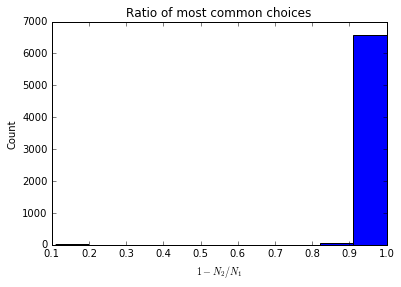

In [94]:
matplotlib.pyplot.hist(ratios)
matplotlib.pyplot.title('Ratio of most common choices')
matplotlib.pyplot.xlabel('$1 - N_2/N_1$')
matplotlib.pyplot.ylabel('Count')
matplotlib.pyplot.show()

## Ratio of maximum clicks to rest of clicks

In [96]:
def max_click_ratios(subject):
    consensus = subject_consensus(subject)
    signature_cluster_counts = consensus['signature_to_cluster_to_count']
    ratios = []
    for clusters in signature_cluster_counts.values():
        values = sorted(clusters.values(), reverse=True)
        if len(values) == 0:
            continue

        if len(values) == 1:
            ratios.append(1)
            continue

        ratios.append(1 - sum(values[1:]) / values[0])
    return ratios

In [97]:
ratios = []
for subject in crowdastro.data.db.radio_subjects.find({'metadata.survey': 'atlas', 'state': 'complete'}).limit(10000):
    ratios.extend(max_click_ratios(subject))

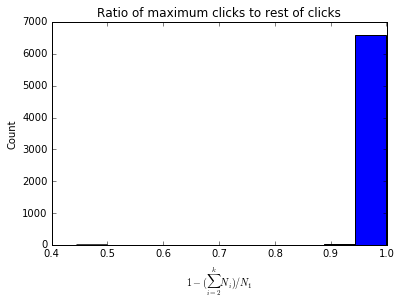

In [98]:
matplotlib.pyplot.hist(ratios)
matplotlib.pyplot.title('Ratio of maximum clicks to rest of clicks')
matplotlib.pyplot.xlabel('$1 - (\sum_{i=2}^k N_i)/N_1$')
matplotlib.pyplot.ylabel('Count')
matplotlib.pyplot.show()

It seems that everyone agreeing is the overwhelmingly majority of cases.